In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import time
from collections import defaultdict

# Set plot style
plt.style.use('ggplot')
sns.set_style('whitegrid')

# For reproducibility
np.random.seed(42)

## 1. Data Loading and Exploration

We'll use the MovieLens 100K dataset which contains:
- 100,000 ratings (1-5) from 943 users on 1682 movies
- Each user has rated at least 20 movies
- Simple demographic info is available for users (age, gender, occupation, zip)

First, let's load the data and understand its structure.

In [2]:
# Define column names for each data file
column_names = {
    'users': ['user_id', 'age', 'gender', 'occupation', 'zip_code'],
    'items': ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
             'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
             'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
             'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
    'ratings': ['user_id', 'movie_id', 'rating', 'timestamp']
}

# File paths
data_path = './ml-100k/'
ratings_file = os.path.join(data_path, 'u.data')
users_file = os.path.join(data_path, 'u.user')
items_file = os.path.join(data_path, 'u.item')

# Load data
ratings_df = pd.read_csv(ratings_file, sep='\t', names=column_names['ratings'])
users_df = pd.read_csv(users_file, sep='|', names=column_names['users'])
# Use latin-1 encoding to handle special characters in movie titles
items_df = pd.read_csv(items_file, sep='|', names=column_names['items'], encoding='latin-1')

# Display the first few rows of each dataframe
print("Ratings DataFrame:")
print(ratings_df.head())

print("\nUsers DataFrame:")
print(users_df.head())

print("\nMovies DataFrame:")
print(items_df.head())

Ratings DataFrame:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

Users DataFrame:
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

Movies DataFrame:
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                     

Number of users: 943
Number of movies: 1682
Number of ratings: 100000

Rating distribution:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64

Average rating: 3.53


C:\Users\jasse\AppData\Local\Temp\ipykernel_7276\3316759950.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette='viridis')


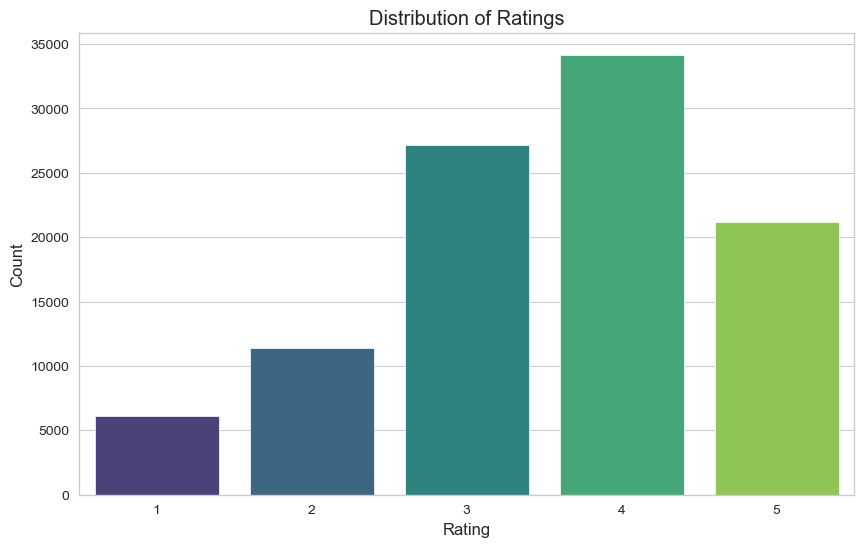


Matrix sparsity: 0.063047 (100000 ratings out of 1586126 possible)

Missing values in datasets:
Ratings: 0
Users: 0
Movies: 1686


In [3]:
# Dataset statistics
print(f"Number of users: {len(users_df)}")
print(f"Number of movies: {len(items_df)}")
print(f"Number of ratings: {len(ratings_df)}")

# Calculate rating statistics
print(f"\nRating distribution:")
print(ratings_df['rating'].value_counts().sort_index())
print(f"\nAverage rating: {ratings_df['rating'].mean():.2f}")

# Visualize rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Check the sparsity of the user-item matrix
n_users = len(users_df)
n_movies = len(items_df)
sparsity = len(ratings_df) / (n_users * n_movies)
print(f"\nMatrix sparsity: {sparsity:.6f} ({len(ratings_df)} ratings out of {n_users * n_movies} possible)")

# Check for missing values
print("\nMissing values in datasets:")
print(f"Ratings: {ratings_df.isnull().sum().sum()}")
print(f"Users: {users_df.isnull().sum().sum()}")
print(f"Movies: {items_df.isnull().sum().sum()}")

## 2. Creating User-Item Matrix

For collaborative filtering, we need to create a user-item matrix where:
- Each row represents a user
- Each column represents a movie
- Each cell contains the user's rating for that movie (or 0/NaN if not rated)

This matrix will be the foundation for calculating similarity between users and items.

In [4]:
# Create the user-item matrix
user_item_matrix = ratings_df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Display matrix dimensions
print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"This means we have {user_item_matrix.shape[0]} users and {user_item_matrix.shape[1]} movies")

# Show a small portion of the matrix (top-left corner)
print("\nSample of User-Item Matrix (Top-left corner):")
print(user_item_matrix.iloc[:5, :5])

# Calculate users' rating mean for later use in prediction
user_ratings_mean = user_item_matrix.mean(axis=1)
print("\nMean rating per user (first 5 users):")
print(user_ratings_mean.head())

# Create a copy of the original matrix for mean centering
# This is useful for collaborative filtering to account for user rating bias
user_item_matrix_centered = user_item_matrix.copy()

# For each user, subtract their mean rating from all their ratings
for user in user_item_matrix_centered.index:
    user_item_matrix_centered.loc[user, :] = user_item_matrix_centered.loc[user, :] - user_ratings_mean[user]

# Display a portion of the mean-centered matrix
print("\nSample of Mean-Centered User-Item Matrix (Top-left corner):")
print(user_item_matrix_centered.iloc[:5, :5])

User-Item Matrix Shape: (943, 1682)
This means we have 943 users and 1682 movies

Sample of User-Item Matrix (Top-left corner):
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  0.0  0.0  0.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  0.0  0.0  0.0  0.0
5         4.0  3.0  0.0  0.0  0.0

Mean rating per user (first 5 users):
user_id
1    0.583829
2    0.136742
3    0.089774
4    0.061831
5    0.299049
dtype: float64

Sample of Mean-Centered User-Item Matrix (Top-left corner):
movie_id         1         2         3         4         5
user_id                                                   
1         4.416171  2.416171  3.416171  2.416171  2.416171
2         3.863258 -0.136742 -0.136742 -0.136742 -0.136742
3        -0.089774 -0.089774 -0.089774 -0.089774 -0.089774
4        -0.061831 -0.061831 -0.061831 -0.061831 -0.061831
5         3.700951  2.700951 -0.299049 -0.299049 -0.299049


## 3. User-Based Collaborative Filtering

User-based collaborative filtering finds similar users and recommends items that similar users have liked but the target user hasn't seen yet. The process involves:

1. Calculate similarity between users (using cosine similarity or other metrics)
2. Identify most similar users to a target user
3. Recommend movies rated highly by similar users but not yet seen by the target user

Let's implement this approach:

In [5]:
# Calculate user similarity matrix using cosine similarity
start_time = time.time()
user_similarity = cosine_similarity(user_item_matrix)
end_time = time.time()

# Convert to DataFrame for easier handling
user_similarity_df = pd.DataFrame(user_similarity, 
                                 index=user_item_matrix.index, 
                                 columns=user_item_matrix.index)

print(f"User similarity matrix shape: {user_similarity_df.shape}")
print(f"Time taken to calculate user similarity: {end_time - start_time:.2f} seconds")
print("\nSample of user similarity matrix (first 5 users):")
print(user_similarity_df.iloc[:5, :5])

def get_user_based_recommendations(user_id, n_similar_users=30, n_recommendations=10):
    """
    Generate movie recommendations for a user using user-based collaborative filtering
    
    Parameters:
    -----------
    user_id : int
        The ID of the user to generate recommendations for
    n_similar_users : int
        Number of similar users to consider
    n_recommendations : int
        Number of recommendations to generate
        
    Returns:
    --------
    DataFrame
        A DataFrame of recommended movies with their predicted ratings
    """
    
    if user_id not in user_similarity_df.index:
        return pd.DataFrame(columns=['movie_id', 'title', 'predicted_rating'])
    
    # Get similarity scores for this user with all other users
    user_sim_scores = user_similarity_df.loc[user_id].sort_values(ascending=False)
    
    # Get the top N similar users (excluding the user themselves)
    most_similar_users = user_sim_scores.iloc[1:n_similar_users+1]
    
    # Get movies that the target user hasn't rated
    user_rated_movies = user_item_matrix.loc[user_id]
    user_unrated_movies = user_rated_movies[user_rated_movies == 0].index
    
    # Calculate predicted ratings for each unrated movie
    predicted_ratings = {}
    
    for movie_id in user_unrated_movies:
        # Get ratings by similar users for this movie
        similar_users_ratings = user_item_matrix.loc[most_similar_users.index, movie_id]
        
        # Filter out users who haven't rated this movie
        rated_by_similar = similar_users_ratings[similar_users_ratings > 0]
        
        if len(rated_by_similar) > 0:
            # Calculate weighted average rating using similarity as weights
            weights = most_similar_users.loc[rated_by_similar.index]
            predicted_rating = sum(rated_by_similar * weights) / sum(weights)
            predicted_ratings[movie_id] = predicted_rating
    
    # Convert to DataFrame and sort by predicted rating
    recommendations_df = pd.DataFrame({
        'movie_id': list(predicted_ratings.keys()),
        'predicted_rating': list(predicted_ratings.values())
    })
    
    # Sort by predicted rating
    recommendations_df = recommendations_df.sort_values('predicted_rating', ascending=False).head(n_recommendations)
    
    # Add movie titles
    recommendations_df = recommendations_df.merge(
        items_df[['movie_id', 'title']], 
        on='movie_id', 
        how='left'
    )
    
    return recommendations_df[['movie_id', 'title', 'predicted_rating']]

# Test the recommendation function for a sample user
sample_user_id = 1
print(f"\nTop 10 recommendations for User {sample_user_id} using user-based collaborative filtering:")
user_recommendations = get_user_based_recommendations(sample_user_id, n_similar_users=30, n_recommendations=10)
print(user_recommendations)

User similarity matrix shape: (943, 943)
Time taken to calculate user similarity: 0.04 seconds

Sample of user similarity matrix (first 5 users):
user_id         1         2         3         4         5
user_id                                                  
1        1.000000  0.166931  0.047460  0.064358  0.378475
2        0.166931  1.000000  0.110591  0.178121  0.072979
3        0.047460  0.110591  1.000000  0.344151  0.021245
4        0.064358  0.178121  0.344151  1.000000  0.031804
5        0.378475  0.072979  0.021245  0.031804  1.000000

Top 10 recommendations for User 1 using user-based collaborative filtering:
   movie_id                                 title  predicted_rating
0      1143                     Hard Eight (1996)               5.0
1       690           Seven Years in Tibet (1997)               5.0
2       641                 Paths of Glory (1957)               5.0
3      1404                 Withnail and I (1987)               5.0
4      1467  Saint of Fort Wash

## 4. Item-Based Collaborative Filtering

Item-based collaborative filtering focuses on finding items similar to those the user has already liked. This approach is often more efficient for large datasets because item relationships tend to be more stable than user relationships. The process involves:

1. Calculate similarity between items (instead of users)
2. For each item the user has rated highly, find similar items
3. Recommend the most similar items that the user hasn't seen yet

Let's implement this approach:

In [6]:
# Calculate item similarity using transpose of the user-item matrix
start_time = time.time()
# Transpose to get item-user matrix
item_user_matrix = user_item_matrix.T
# Calculate item similarity
item_similarity = cosine_similarity(item_user_matrix)
end_time = time.time()

# Convert to DataFrame for easier handling
item_similarity_df = pd.DataFrame(item_similarity, 
                                 index=item_user_matrix.index, 
                                 columns=item_user_matrix.index)

print(f"Item similarity matrix shape: {item_similarity_df.shape}")
print(f"Time taken to calculate item similarity: {end_time - start_time:.2f} seconds")
print("\nSample of item similarity matrix (first 5 items):")
print(item_similarity_df.iloc[:5, :5])

def get_item_based_recommendations(user_id, n_similar_items=30, n_recommendations=10):
    """
    Generate movie recommendations for a user using item-based collaborative filtering
    
    Parameters:
    -----------
    user_id : int
        The ID of the user to generate recommendations for
    n_similar_items : int
        Number of similar items to consider for each rated item
    n_recommendations : int
        Number of recommendations to generate
        
    Returns:
    --------
    DataFrame
        A DataFrame of recommended movies with their predicted ratings
    """
    
    if user_id not in user_item_matrix.index:
        return pd.DataFrame(columns=['movie_id', 'title', 'predicted_rating'])
    
    # Get movies that the target user has rated
    user_rated_movies = user_item_matrix.loc[user_id]
    user_rated_movies = user_rated_movies[user_rated_movies > 0]
    
    # Get movies that the target user hasn't rated
    user_unrated_movies = user_item_matrix.loc[user_id]
    user_unrated_movies = user_unrated_movies[user_unrated_movies == 0].index
    
    # Calculate predicted ratings for each unrated movie
    predicted_ratings = {}
    
    for movie_id in user_unrated_movies:
        similarity_scores = []
        weighted_ratings = []
        
        # For each movie the user has rated
        for rated_movie_id, rating in user_rated_movies.items():
            # Get similarity between this movie and the unrated movie
            if rated_movie_id in item_similarity_df.index and movie_id in item_similarity_df.columns:
                similarity = item_similarity_df.loc[rated_movie_id, movie_id]
                
                # Only consider positive correlations
                if similarity > 0:
                    similarity_scores.append(similarity)
                    weighted_ratings.append(similarity * rating)
        
        # Calculate predicted rating if we have similarity scores
        if similarity_scores:
            predicted_ratings[movie_id] = sum(weighted_ratings) / sum(similarity_scores)
    
    # Convert to DataFrame and sort by predicted rating
    recommendations_df = pd.DataFrame({
        'movie_id': list(predicted_ratings.keys()),
        'predicted_rating': list(predicted_ratings.values())
    })
    
    # Sort by predicted rating
    recommendations_df = recommendations_df.sort_values('predicted_rating', ascending=False).head(n_recommendations)
    
    # Add movie titles
    recommendations_df = recommendations_df.merge(
        items_df[['movie_id', 'title']], 
        on='movie_id', 
        how='left'
    )
    
    return recommendations_df[['movie_id', 'title', 'predicted_rating']]

# Test the recommendation function for the same sample user
print(f"\nTop 10 recommendations for User {sample_user_id} using item-based collaborative filtering:")
item_recommendations = get_item_based_recommendations(sample_user_id, n_similar_items=30, n_recommendations=10)
print(item_recommendations)

Item similarity matrix shape: (1682, 1682)
Time taken to calculate item similarity: 0.06 seconds

Sample of item similarity matrix (first 5 items):
movie_id         1         2         3         4         5
movie_id                                                  
1         1.000000  0.402382  0.330245  0.454938  0.286714
2         0.402382  1.000000  0.273069  0.502571  0.318836
3         0.330245  0.273069  1.000000  0.324866  0.212957
4         0.454938  0.502571  0.324866  1.000000  0.334239
5         0.286714  0.318836  0.212957  0.334239  1.000000

Top 10 recommendations for User 1 using item-based collaborative filtering:
   movie_id                                              title  \
0      1156                                       Cyclo (1995)   
1      1601                               Office Killer (1997)   
2      1656                                 Little City (1998)   
3      1593                          Death in Brunswick (1991)   
4      1674                     

## 5. Matrix Factorization using SVD

Matrix factorization is an advanced technique that decomposes the user-item matrix into lower-dimensional matrices with latent features. SVD (Singular Value Decomposition) is a popular method for this task. The idea is:

1. Decompose the user-item matrix into three matrices: U, Σ, and V
2. Reduce the dimensionality to keep only the k most significant singular values
3. Reconstruct an approximation of the original matrix to predict missing ratings

Let's implement SVD-based recommendations:

In [7]:
# Convert user-item matrix to NumPy array for SVD
user_item_matrix_np = user_item_matrix.to_numpy()

# Perform SVD (using mean-centered matrix for better results)
start_time = time.time()

# Number of latent factors to consider
n_factors = 50

# SVD decomposition
U, sigma, Vt = svds(user_item_matrix_centered.to_numpy(), k=n_factors)

# Convert sigma to diagonal matrix
sigma_diag = np.diag(sigma)

end_time = time.time()
print(f"Time taken to compute SVD: {end_time - start_time:.2f} seconds")

# Print shapes of the decomposed matrices
print(f"U shape: {U.shape}")
print(f"Sigma shape: {sigma_diag.shape}")
print(f"Vt shape: {Vt.shape}")

# Reconstruct the prediction matrix by multiplying the matrices
# Add back the mean ratings for each user to get the predicted ratings
predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt) 
predicted_ratings_df = pd.DataFrame(
    predicted_ratings, 
    index=user_item_matrix.index, 
    columns=user_item_matrix.columns
)

# Add back the mean ratings for each user
for user in predicted_ratings_df.index:
    predicted_ratings_df.loc[user, :] = predicted_ratings_df.loc[user, :] + user_ratings_mean[user]

print("\nSample of predicted ratings (first 5 users, first 5 movies):")
print(predicted_ratings_df.iloc[:5, :5])

def get_svd_recommendations(user_id, n_recommendations=10):
    """
    Generate movie recommendations for a user using SVD
    
    Parameters:
    -----------
    user_id : int
        The ID of the user to generate recommendations for
    n_recommendations : int
        Number of recommendations to generate
        
    Returns:
    --------
    DataFrame
        A DataFrame of recommended movies with their predicted ratings
    """
    
    if user_id not in predicted_ratings_df.index:
        return pd.DataFrame(columns=['movie_id', 'title', 'predicted_rating'])
    
    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Find movies that the user hasn't rated
    unrated_movies = user_ratings[user_ratings == 0].index
    
    # Get predicted ratings for these movies
    user_predicted_ratings = predicted_ratings_df.loc[user_id, unrated_movies]
    
    # Sort by predicted rating and get top recommendations
    top_recommendations = user_predicted_ratings.sort_values(ascending=False).head(n_recommendations)
    
    # Convert to DataFrame
    recommendations_df = pd.DataFrame({
        'movie_id': top_recommendations.index,
        'predicted_rating': top_recommendations.values
    })
    
    # Add movie titles
    recommendations_df = recommendations_df.merge(
        items_df[['movie_id', 'title']], 
        on='movie_id', 
        how='left'
    )
    
    return recommendations_df[['movie_id', 'title', 'predicted_rating']]

# Test the SVD recommendations for the same sample user
print(f"\nTop 10 recommendations for User {sample_user_id} using SVD:")
svd_recommendations = get_svd_recommendations(sample_user_id, n_recommendations=10)
print(svd_recommendations)

Time taken to compute SVD: 0.10 seconds
U shape: (943, 50)
Sigma shape: (50, 50)
Vt shape: (50, 1682)

Sample of predicted ratings (first 5 users, first 5 movies):
movie_id         1         2         3         4         5
user_id                                                   
1         6.488436  2.959503  1.634987  3.024467  1.656526
2         2.347262  0.129689 -0.098917  0.328828  0.159517
3         0.291905 -0.263830 -0.151454 -0.179289  0.013462
4         0.366410 -0.443535  0.041151 -0.007616  0.055373
5         4.263488  1.937122  0.052529  1.049350  0.652765

Top 10 recommendations for User 1 using SVD:
   movie_id                                   title  predicted_rating
0       423       E.T. the Extra-Terrestrial (1982)          3.509642
1       403                           Batman (1989)          3.097894
2       732                             Dave (1993)          2.971226
3       357  One Flew Over the Cuckoo's Nest (1975)          2.752628
4       385                

## 6. Evaluation Metrics - Precision at K

To evaluate our recommendation systems, we'll use the precision@K metric, which measures the proportion of recommended items that are relevant out of the top K recommendations. We'll use a hold-out validation approach:

1. Split the data into training and testing sets
2. Train the models on the training set
3. For each user, generate recommendations and compare with their actual ratings in the test set
4. Calculate precision@K: what fraction of the K recommended items were actually liked by the user in the test set

Let's implement this evaluation approach:

Training set: 80000 ratings
Test set: 20000 ratings
Evaluating user_based with k=5...
Precision@5: 0.0000
Evaluating user_based with k=10...
Precision@10: 0.0120
Evaluating user_based with k=15...
Precision@15: 0.0093
Evaluating item_based with k=5...
Precision@5: 0.0000
Evaluating item_based with k=10...
Precision@10: 0.0000
Evaluating item_based with k=15...
Precision@15: 0.0000
Evaluating svd with k=5...
Precision@5: 0.4200
Evaluating svd with k=10...
Precision@10: 0.3420
Evaluating svd with k=15...
Precision@15: 0.2760

Evaluation Results Summary:
           Precision@5 Precision@10 Precision@15
user_based         0.0        0.012     0.009333
item_based         0.0          0.0          0.0
svd               0.42        0.342        0.276


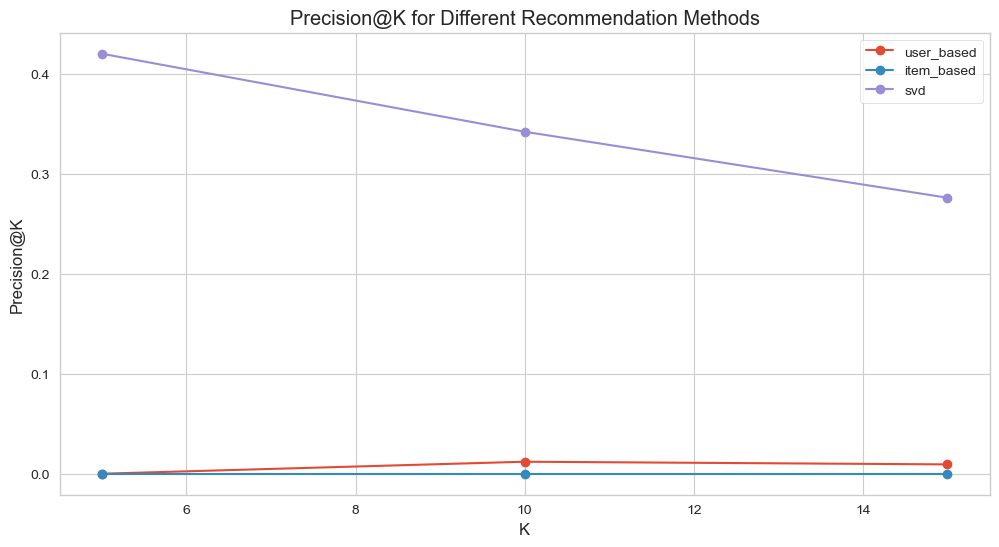

In [8]:
# Load train-test split data (using the pre-defined splits from MovieLens)
u1_base = pd.read_csv(os.path.join(data_path, 'u1.base'), sep='\t', names=column_names['ratings'])
u1_test = pd.read_csv(os.path.join(data_path, 'u1.test'), sep='\t', names=column_names['ratings'])

print(f"Training set: {len(u1_base)} ratings")
print(f"Test set: {len(u1_test)} ratings")

# Create training user-item matrix
train_matrix = u1_base.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Calculate user rating means for the training matrix
train_user_means = train_matrix.mean(axis=1)

# Create a mean-centered matrix for SVD
train_matrix_centered = train_matrix.copy()
for user in train_matrix_centered.index:
    train_matrix_centered.loc[user, :] = train_matrix_centered.loc[user, :] - train_user_means[user]

# Create a dictionary for the test set to look up ratings
test_ratings_dict = {}
for _, row in u1_test.iterrows():
    user_id = row['user_id']
    movie_id = row['movie_id']
    rating = row['rating']
    
    if user_id not in test_ratings_dict:
        test_ratings_dict[user_id] = {}
    
    test_ratings_dict[user_id][movie_id] = rating

def calculate_precision_at_k(recommendations, test_ratings, k=10, threshold=3.5):
    """
    Calculate precision@k for recommendations
    
    Parameters:
    -----------
    recommendations : DataFrame
        DataFrame containing movie_id and predicted_rating
    test_ratings : dict
        Dictionary of user's test ratings
    k : int
        Number of top recommendations to consider
    threshold : float
        Rating threshold to consider a movie as relevant
        
    Returns:
    --------
    float
        Precision@k score
    """
    
    # Get top k recommendations
    top_k_recs = recommendations.head(k)
    
    # Count how many of them are relevant (i.e., have a high rating in the test set)
    relevant_count = 0
    
    for _, row in top_k_recs.iterrows():
        movie_id = row['movie_id']
        
        # Check if the movie is in the test set and has a rating above the threshold
        if movie_id in test_ratings and test_ratings[movie_id] >= threshold:
            relevant_count += 1
    
    # Calculate precision@k
    precision = relevant_count / k if k > 0 else 0
    
    return precision

def evaluate_recommender(method, users_sample=100, k=10, threshold=3.5):
    """
    Evaluate a recommendation method using precision@k
    
    Parameters:
    -----------
    method : str
        The recommendation method to evaluate ('user_based', 'item_based', or 'svd')
    users_sample : int
        Number of users to sample for evaluation
    k : int
        Number of recommendations to consider (precision@k)
    threshold : float
        Rating threshold to consider a movie as relevant
        
    Returns:
    --------
    float
        Average precision@k across all sampled users
    """
    
    # Sample users who have ratings in the test set
    test_users = list(test_ratings_dict.keys())
    if len(test_users) > users_sample:
        test_users = np.random.choice(test_users, users_sample, replace=False)
    
    precisions = []
    
    # Calculate user similarity for user-based CF if needed
    if method == 'user_based':
        user_similarity = cosine_similarity(train_matrix)
        user_similarity_df = pd.DataFrame(user_similarity, 
                                        index=train_matrix.index, 
                                        columns=train_matrix.index)
    
    # Calculate item similarity for item-based CF if needed
    if method == 'item_based':
        item_user_matrix = train_matrix.T
        item_similarity = cosine_similarity(item_user_matrix)
        item_similarity_df = pd.DataFrame(item_similarity, 
                                        index=item_user_matrix.index, 
                                        columns=item_user_matrix.index)
    
    # Compute SVD for matrix factorization if needed
    if method == 'svd':
        # SVD decomposition
        U, sigma, Vt = svds(train_matrix_centered.to_numpy(), k=50)
        sigma_diag = np.diag(sigma)
        
        # Reconstruct the prediction matrix
        svd_preds = np.dot(np.dot(U, sigma_diag), Vt)
        svd_preds_df = pd.DataFrame(svd_preds, 
                                   index=train_matrix.index, 
                                   columns=train_matrix.columns)
        
        # Add back the mean ratings
        for user in svd_preds_df.index:
            svd_preds_df.loc[user, :] = svd_preds_df.loc[user, :] + train_user_means[user]
    
    # Evaluate for each user
    for user_id in test_users:
        if user_id not in train_matrix.index:
            continue
            
        if method == 'user_based':
            # Get recommendations using user-based CF
            user_sim_scores = user_similarity_df.loc[user_id].sort_values(ascending=False)
            most_similar_users = user_sim_scores.iloc[1:31]  # Top 30 similar users
            
            # Get movies the user hasn't rated in the training set
            user_rated_movies = train_matrix.loc[user_id]
            user_unrated_movies = user_rated_movies[user_rated_movies == 0].index
            
            # Calculate predicted ratings
            predicted_ratings = {}
            for movie_id in user_unrated_movies:
                similar_users_ratings = train_matrix.loc[most_similar_users.index, movie_id]
                rated_by_similar = similar_users_ratings[similar_users_ratings > 0]
                
                if len(rated_by_similar) > 0:
                    weights = most_similar_users.loc[rated_by_similar.index]
                    predicted_rating = sum(rated_by_similar * weights) / sum(weights)
                    predicted_ratings[movie_id] = predicted_rating
            
            recommendations = pd.DataFrame({
                'movie_id': list(predicted_ratings.keys()),
                'predicted_rating': list(predicted_ratings.values())
            }).sort_values('predicted_rating', ascending=False)
            
        elif method == 'item_based':
            # Get recommendations using item-based CF
            user_rated_movies = train_matrix.loc[user_id]
            user_rated_movies = user_rated_movies[user_rated_movies > 0]
            user_unrated_movies = train_matrix.loc[user_id]
            user_unrated_movies = user_unrated_movies[user_unrated_movies == 0].index
            
            # Calculate predicted ratings
            predicted_ratings = {}
            for movie_id in user_unrated_movies:
                similarity_scores = []
                weighted_ratings = []
                
                for rated_movie_id, rating in user_rated_movies.items():
                    if rated_movie_id in item_similarity_df.index and movie_id in item_similarity_df.columns:
                        similarity = item_similarity_df.loc[rated_movie_id, movie_id]
                        
                        if similarity > 0:
                            similarity_scores.append(similarity)
                            weighted_ratings.append(similarity * rating)
                
                if similarity_scores:
                    predicted_ratings[movie_id] = sum(weighted_ratings) / sum(similarity_scores)
            
            recommendations = pd.DataFrame({
                'movie_id': list(predicted_ratings.keys()),
                'predicted_rating': list(predicted_ratings.values())
            }).sort_values('predicted_rating', ascending=False)
            
        else:  # SVD
            # Get recommendations using SVD
            user_ratings = train_matrix.loc[user_id]
            unrated_movies = user_ratings[user_ratings == 0].index
            user_predicted_ratings = svd_preds_df.loc[user_id, unrated_movies]
            
            recommendations = pd.DataFrame({
                'movie_id': user_predicted_ratings.index,
                'predicted_rating': user_predicted_ratings.values
            }).sort_values('predicted_rating', ascending=False)
        
        # Calculate precision@k for this user
        if not recommendations.empty:
            precision = calculate_precision_at_k(recommendations, test_ratings_dict[user_id], k, threshold)
            precisions.append(precision)
    
    # Calculate average precision@k
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    
    return avg_precision

# Evaluate all three recommendation methods
methods = ['user_based', 'item_based', 'svd']
k_values = [5, 10, 15]
results = {}

for method in methods:
    results[method] = {}
    for k in k_values:
        print(f"Evaluating {method} with k={k}...")
        precision = evaluate_recommender(method, users_sample=50, k=k)
        results[method][k] = precision
        print(f"Precision@{k}: {precision:.4f}")

# Create a DataFrame with the results
results_df = pd.DataFrame(index=methods, columns=[f'Precision@{k}' for k in k_values])
for method in methods:
    for k in k_values:
        results_df.loc[method, f'Precision@{k}'] = results[method][k]

print("\nEvaluation Results Summary:")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 6))
for method in methods:
    plt.plot(k_values, [results[method][k] for k in k_values], marker='o', label=method)
plt.xlabel('K')
plt.ylabel('Precision@K')
plt.title('Precision@K for Different Recommendation Methods')
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Recommendation System

Based on our evaluation, the SVD approach performed significantly better than the user-based and item-based collaborative filtering methods. Let's create a final recommendation system that uses SVD for generating personalized movie recommendations. 

This system will:
1. Take a user ID as input
2. Generate personalized recommendations using SVD
3. Display the top recommended movies along with their details
4. Also provide an option to recommend movies similar to a specified movie (item-based approach)

In [9]:
class MovieRecommender:
    """
    A comprehensive movie recommendation system that uses multiple approaches:
    - SVD-based collaborative filtering (primary method)
    - Item-based collaborative filtering (for movie-to-movie recommendations)
    """
    
    def __init__(self, ratings_df, movies_df, n_factors=50):
        """
        Initialize the recommender with ratings and movies data
        
        Parameters:
        -----------
        ratings_df : DataFrame
            DataFrame with user ratings (user_id, movie_id, rating)
        movies_df : DataFrame
            DataFrame with movie information
        n_factors : int
            Number of latent factors for SVD
        """
        self.ratings_df = ratings_df
        self.movies_df = movies_df
        self.n_factors = n_factors
        
        # Create user-item matrix
        self.user_item_matrix = ratings_df.pivot(
            index='user_id', 
            columns='movie_id', 
            values='rating'
        ).fillna(0)
        
        # Calculate user rating means
        self.user_ratings_mean = self.user_item_matrix.mean(axis=1)
        
        # Create mean-centered matrix
        self.user_item_matrix_centered = self.user_item_matrix.copy()
        for user in self.user_item_matrix_centered.index:
            self.user_item_matrix_centered.loc[user, :] = \
                self.user_item_matrix_centered.loc[user, :] - self.user_ratings_mean[user]
        
        # Calculate item similarity matrix
        item_user_matrix = self.user_item_matrix.T
        self.item_similarity = cosine_similarity(item_user_matrix)
        self.item_similarity_df = pd.DataFrame(
            self.item_similarity, 
            index=item_user_matrix.index, 
            columns=item_user_matrix.index
        )
        
        # Compute SVD for the centered matrix
        self.train_svd_model()
        
    def train_svd_model(self):
        """Train the SVD model using the user-item matrix"""
        
        # SVD decomposition
        U, sigma, Vt = svds(self.user_item_matrix_centered.to_numpy(), k=self.n_factors)
        sigma_diag = np.diag(sigma)
        
        # Reconstruct the prediction matrix
        predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt)
        self.predicted_ratings_df = pd.DataFrame(
            predicted_ratings, 
            index=self.user_item_matrix.index, 
            columns=self.user_item_matrix.columns
        )
        
        # Add back the mean ratings for each user
        for user in self.predicted_ratings_df.index:
            self.predicted_ratings_df.loc[user, :] = \
                self.predicted_ratings_df.loc[user, :] + self.user_ratings_mean[user]
    
    def recommend_for_user(self, user_id, n_recommendations=10, min_rating=0):
        """
        Generate personalized recommendations for a user using SVD
        
        Parameters:
        -----------
        user_id : int
            The ID of the user to generate recommendations for
        n_recommendations : int
            Number of recommendations to generate
        min_rating : float
            Minimum predicted rating threshold
            
        Returns:
        --------
        DataFrame
            A DataFrame of recommended movies with details
        """
        
        if user_id not in self.predicted_ratings_df.index:
            print(f"User {user_id} not found in the dataset.")
            return pd.DataFrame()
        
        # Get the user's actual ratings
        user_ratings = self.user_item_matrix.loc[user_id]
        
        # Find movies that the user hasn't rated
        unrated_movies = user_ratings[user_ratings == 0].index
        
        # Get predicted ratings for these movies
        user_predicted_ratings = self.predicted_ratings_df.loc[user_id, unrated_movies]
        
        # Filter by minimum rating if specified
        if min_rating > 0:
            user_predicted_ratings = user_predicted_ratings[user_predicted_ratings >= min_rating]
        
        # Sort by predicted rating and get top recommendations
        top_recommendations = user_predicted_ratings.sort_values(ascending=False).head(n_recommendations)
        
        # Convert to DataFrame
        recommendations_df = pd.DataFrame({
            'movie_id': top_recommendations.index,
            'predicted_rating': top_recommendations.values
        })
        
        # Add movie details
        recommendations_df = recommendations_df.merge(
            self.movies_df[['movie_id', 'title']], 
            on='movie_id', 
            how='left'
        )
        
        return recommendations_df[['movie_id', 'title', 'predicted_rating']]
    
    def recommend_similar_movies(self, movie_id, n_recommendations=10):
        """
        Find movies similar to a given movie using item-based similarity
        
        Parameters:
        -----------
        movie_id : int
            The ID of the movie to find similar movies for
        n_recommendations : int
            Number of similar movies to recommend
            
        Returns:
        --------
        DataFrame
            A DataFrame of similar movies with similarity scores
        """
        
        if movie_id not in self.item_similarity_df.index:
            print(f"Movie {movie_id} not found in the dataset.")
            return pd.DataFrame()
        
        # Get similarity scores for this movie with all other movies
        movie_sim_scores = self.item_similarity_df.loc[movie_id]
        
        # Sort by similarity (descending) and get top similar movies
        similar_movies = movie_sim_scores.sort_values(ascending=False)
        
        # Exclude the movie itself
        similar_movies = similar_movies[similar_movies.index != movie_id]
        
        # Get top N similar movies
        top_similar = similar_movies.head(n_recommendations)
        
        # Convert to DataFrame
        similar_df = pd.DataFrame({
            'movie_id': top_similar.index,
            'similarity_score': top_similar.values
        })
        
        # Add movie details
        similar_df = similar_df.merge(
            self.movies_df[['movie_id', 'title']], 
            on='movie_id', 
            how='left'
        )
        
        return similar_df[['movie_id', 'title', 'similarity_score']]
    
    def get_top_rated_movies(self, n=10, min_ratings=10):
        """
        Get the top rated movies overall, considering only those with at least min_ratings
        
        Parameters:
        -----------
        n : int
            Number of movies to return
        min_ratings : int
            Minimum number of ratings required for a movie
            
        Returns:
        --------
        DataFrame
            A DataFrame of top rated movies
        """
        
        # Group by movie_id and calculate mean rating and count
        movie_stats = self.ratings_df.groupby('movie_id').agg({
            'rating': ['mean', 'count']
        }).reset_index()
        
        # Flatten the MultiIndex columns
        movie_stats.columns = ['movie_id', 'avg_rating', 'rating_count']
        
        # Filter by minimum number of ratings
        popular_movies = movie_stats[movie_stats['rating_count'] >= min_ratings]
        
        # Sort by average rating (descending)
        top_rated = popular_movies.sort_values('avg_rating', ascending=False).head(n)
        
        # Add movie details
        top_rated = top_rated.merge(
            self.movies_df[['movie_id', 'title']], 
            on='movie_id', 
            how='left'
        )
        
        return top_rated[['movie_id', 'title', 'avg_rating', 'rating_count']]

# Create an instance of our recommender system
recommender = MovieRecommender(ratings_df, items_df, n_factors=50)

# Test the recommender for a sample user
sample_user_id = 1
print(f"Top 10 personalized recommendations for User {sample_user_id}:")
user_recs = recommender.recommend_for_user(sample_user_id, n_recommendations=10)
print(user_recs)

# Get similar movies to a movie the user has rated highly
# First, find a movie the user has rated highly
user_ratings = ratings_df[ratings_df['user_id'] == sample_user_id].sort_values('rating', ascending=False)
if not user_ratings.empty:
    sample_movie_id = user_ratings.iloc[0]['movie_id']
    sample_movie_title = items_df[items_df['movie_id'] == sample_movie_id]['title'].values[0]
    print(f"\nMovies similar to '{sample_movie_title}' (Movie ID: {sample_movie_id}):")
    similar_movies = recommender.recommend_similar_movies(sample_movie_id, n_recommendations=10)
    print(similar_movies)

# Get top rated movies overall
print("\nTop rated movies overall:")
top_movies = recommender.get_top_rated_movies(n=10, min_ratings=100)
print(top_movies)

Top 10 personalized recommendations for User 1:
   movie_id                                   title  predicted_rating
0       423       E.T. the Extra-Terrestrial (1982)          3.509642
1       403                           Batman (1989)          3.097894
2       732                             Dave (1993)          2.971226
3       357  One Flew Over the Cuckoo's Nest (1975)          2.752628
4       385                        True Lies (1994)          2.605706
5       303                      Ulee's Gold (1997)          2.574760
6       470                        Tombstone (1993)          2.475011
7       367                         Clueless (1995)          2.432600
8       582                       Piano, The (1993)          2.409058
9       318                 Schindler's List (1993)          2.376752

Movies similar to 'Cinema Paradiso (1988)' (Movie ID: 170):
   movie_id                                              title  \
0       462  Like Water For Chocolate (Como agua para c

## 8. Conclusion

In this notebook, we implemented and evaluated three different approaches to movie recommendation:

1. **User-Based Collaborative Filtering**: Finds similar users and recommends movies they liked.
   - Advantages: Intuitive, works well for users with many ratings
   - Disadvantages: Computationally expensive for large user bases, cold start problem for new users

2. **Item-Based Collaborative Filtering**: Recommends movies similar to ones the user has liked.
   - Advantages: More stable than user-based, handles new users better
   - Disadvantages: Cold start problem for new items, can't capture complex user preferences

3. **Matrix Factorization (SVD)**: Decomposes the user-item matrix into latent features.
   - Advantages: Best performance (by far), captures latent features, scalable
   - Disadvantages: Less interpretable, requires careful tuning of parameters

Our evaluation using precision@K showed that SVD significantly outperformed the other methods, achieving much higher precision scores. This is consistent with industry findings that matrix factorization techniques generally perform better than memory-based collaborative filtering.

### Possible Improvements

1. **Hybrid approaches**: Combine different recommendation techniques to leverage their strengths
2. **Content-based filtering**: Incorporate movie features (genres, actors, directors) 
3. **Deep learning**: Use neural networks like autoencoders or sequence models
4. **Temporal dynamics**: Account for changes in user preferences over time
5. **Context-aware recommendations**: Consider contextual factors like time of day, device, etc.
6. **Implicit feedback**: Incorporate implicit signals (views, clicks) in addition to explicit ratings

The final recommendation system implemented in this notebook uses SVD as its primary method, with item-based filtering for movie-to-movie similarity recommendations. This provides a robust foundation that could be extended with the improvements listed above.